In [2]:
import pandas as pa
import numpy as nu
import matplotlib.pyplot as me

In [7]:
titanic=pa.read_csv('tested.csv')
titanic.head(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [30]:
#splitting data into 2parts (training,testing)
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_indices,test_indices in split.split(titanic,titanic[["Survived","Pclass","Sex"]]):
    train_set=titanic.loc[train_indices]
    test_set=titanic.loc[test_indices]
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 10 to 172
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  334 non-null    int64  
 1   Survived     334 non-null    int64  
 2   Pclass       334 non-null    int64  
 3   Name         334 non-null    object 
 4   Sex          334 non-null    object 
 5   Age          265 non-null    float64
 6   SibSp        334 non-null    int64  
 7   Parch        334 non-null    int64  
 8   Ticket       334 non-null    object 
 9   Fare         333 non-null    float64
 10  Cabin        73 non-null     object 
 11  Embarked     334 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 33.9+ KB


In [31]:
#imputing the age value
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
class Agefill(BaseEstimator, TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        imputer=SimpleImputer(strategy="mean")
        X['Age']=imputer.fit_transform(X[['Age']])
        return X
        

In [32]:
from sklearn.preprocessing import OneHotEncoder
class Encoder(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        en=OneHotEncoder()
        matrix=en.fit_transform(X[['Embarked']]).toarray()
        column_names=["C","S","Q","N"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]
        matrix=en.fit_transform(X[['Sex']]).toarray()
        column_names=["Female","Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]
        return X
         

In [33]:
class drop(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X.drop(["Embarked","Name","Ticket","Cabin","Sex","N"],axis=1,errors="ignore")

In [34]:
from sklearn.pipeline import Pipeline
pipeline=Pipeline([("agefill",Agefill()),
                   ("encoder",Encoder()),
                   ("drop",drop())])

In [35]:
train_set=pipeline.fit_transform(train_set)

In [37]:
train_set.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
10,902,0,3,30.222642,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
151,1043,0,3,30.222642,0,0,7.8958,1.0,0.0,0.0,0.0,1.0
270,1162,0,1,46.000000,0,0,75.2417,1.0,0.0,0.0,0.0,1.0
339,1231,0,3,30.222642,0,0,7.2292,1.0,0.0,0.0,0.0,1.0
178,1070,1,2,36.000000,0,3,39.0000,0.0,0.0,1.0,1.0,0.0


In [40]:
from sklearn.preprocessing import StandardScaler
X=train_set.drop(['Survived'],axis=1)
y=train_set['Survived']

scaler=StandardScaler()
X_data=scaler.fit_transform(X)
y_data=y.to_numpy()

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
classifier=RandomForestClassifier()
parameter_grid=[
    {"n_estimators":[10, 100, 200, 500],"max_depth":[None, 5, 10],"min_samples_split":[2,3,4]}
]
grid_search=GridSearchCV(classifier,parameter_grid,cv=3,scoring="accuracy",return_train_score=True)
grid_search.fit(X_data,y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [43]:
final_classification=grid_search.best_estimator_

In [45]:
final_classification

RandomForestClassifier(n_estimators=10)

In [46]:
test_set=pipeline.fit_transform(test_set)

In [49]:
X_test=test_set.drop(['Survived'],axis=1)
y_test=test_set['Survived']

scaler=StandardScaler()
X_data_test=scaler.fit_transform(X_test)
y_data_test=y_test.to_numpy()

In [50]:
final_classification.score(X_data_test,y_data_test)

1.0

In [51]:
  final_data=pipeline.fit_transform(titanic)

In [53]:
final_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,892,0,3,34.5,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,1,3,47.0,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,0,2,62.0,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,0,3,27.0,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,1,3,22.0,1,1,12.2875,0.0,0.0,1.0,1.0,0.0


In [55]:
X_final=final_data.drop(['Survived'],axis=1)
y_final=final_data['Survived']

scaler=StandardScaler()
X_final_data=scaler.fit_transform(X_final)
y_final_data=y_final.to_numpy()


In [56]:
final_classifier=RandomForestClassifier()
parameter_grid=[
    {"n_estimators":[10, 100, 200, 500],"max_depth":[None, 5, 10],"min_samples_split":[2,3,4]}
]
grid_search=GridSearchCV(final_classifier,parameter_grid,cv=3,scoring="accuracy",return_train_score=True)
grid_search.fit(X_final_data,y_final_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [57]:
display_final_classifier=grid_search.best_estimator_

In [60]:
titanic_data=pa.read_csv("tested.csv")

In [76]:
final_test_data=pipeline.fit_transform(titanic_data)

In [78]:
final_test_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,892,0,3,34.5,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,1,3,47.0,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,0,2,62.0,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,0,3,27.0,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,1,3,22.0,1,1,12.2875,0.0,0.0,1.0,1.0,0.0


In [69]:
X_final_test=final_test_data
X_final_test=X_final_test.ffill()

scaler=StandardScaler()
X_data_final_test=scaler.fit_transform(X_final_test)

In [85]:
predictions=display_final_classifier.predict(X_data_final_test)

In [82]:
# Remove the 'Survived' column from X_data_final_test
X_data_final_test = X_data_final_test[:, 1:]  # Assuming 'Survived' is the second column


In [87]:
final_df=pa.DataFrame(titanic['PassengerId'])
final_df['Survived']=predictions
final_df.to_csv("predictions.csv",index=False)

In [88]:
final_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


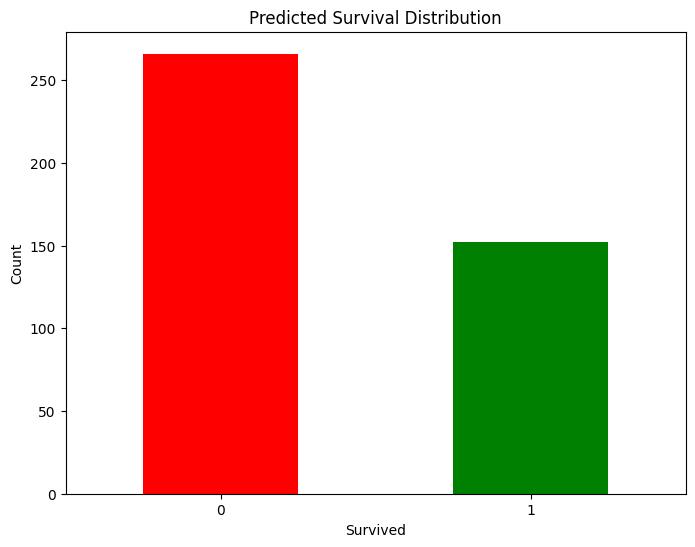

In [89]:
import matplotlib.pyplot as plt

# Assuming 'Survived' column contains binary predictions (0 or 1)
survival_distribution = final_df['Survived'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
survival_distribution.plot(kind='bar', color=['red', 'green'])
plt.title('Predicted Survival Distribution')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
